In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, ops
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm

os.environ["KERAS_BACKEND"] = "tensorflow"

### Useful Functions

In [81]:
#Plotting Results: Total Loss, KL Loss, Reconstruction Loss

def ax_standard(ax):

    ax.grid(True, alpha=0.5)
    ax.set_xlabel("Epoch")

def plot_results(history):

    line_color = "#f07167"

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.tight_layout(pad=5)

    ax[0].plot(history["loss"], color = line_color)
    ax_standard(ax[0])
    ax[0].set_ylabel("Total Loss")


    ax[1].plot(history["kl_loss"], color = line_color)
    ax_standard(ax[1])
    ax[1].set_ylabel("KL Loss")


    ax[2].plot(history["reconstruction_loss"], color = line_color)
    ax_standard(ax[2])
    ax[2].set_ylabel("Reconstruction Loss")

In [82]:
def time_interval():
  r""""
  Returns two random time points
  """

  prob = random.random()
  if prob < 0.8: #time interval [1,10] with prob 0.8
    t2 = random.randint(10,199) # max time interval is 10, so if t2 < 10 t1 will be negative if dt = 10
    t1 = random.randint(t2-10,t2-1)
  else: #time interval [1,120] with prob 0.2
    t2 = random.randint(120,199)
    t1 = random.randint(t2-120,t2-1)

  return t1, t2


In [83]:
def log_normal_pdf(x, mean, logvar):
  return - 0.5 *(
      tf.reduce_sum(tf.math.log(2. * np.pi) + logvar + tf.square(x - mean)/ tf.exp(logvar), axis = -1)
  )

def A_poly(A, power):
    r""""
    Returns a decresing polynomial in powers of A.
    Ex: For power = 3, returns A^3 + A^2 + A + 1
    """
    if power == 0: return 1
    return pow(A,power) + A_poly(A, power-1)


### Generate Data

Training Data Shape: (1000, 200, 1)


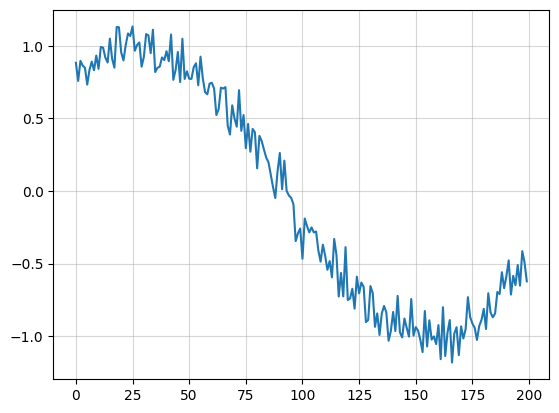

In [5]:
# Generate synthetic sine wave sequences
def generate_sine_data(num_samples=1000, sequence_length=200, noise_level=0.1):
    """
    Generate sine wave sequences with slight variations.
    num_samples: Number of sequences.
    sequence_length: Number of time steps per sequence.
    noise_level: Amplitude of added random noise.
    Returns: (num_samples, sequence_length, 1) shape dataset
    """
    X = []
    np.random.seed(100)

    for _ in range(num_samples):
        #freq = np.random.uniform(0.1, 0.5)  # Random frequency
        freq = np.random.uniform(0.5, 1)  # Random frequency
        phase = np.random.uniform(0, np.pi)  # Random phase shift
        sequence = np.sin(np.linspace(0, 2 * np.pi * freq, sequence_length) + phase)
        sequence += np.random.normal(0, noise_level, sequence_length)  # Add noise
        X.append(sequence)

    X = np.array(X).reshape(num_samples, sequence_length, 1)  # Reshape for LSTM input
    return X

# Generate data
X_train = generate_sine_data(num_samples=1000)

# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).batch(32)
print("Training Data Shape:", X_train.shape)

#Plot Sample Data
plt.plot(X_train[0])
plt.grid(True, alpha=0.5)

### Building the Model

Based on the paper TEMPORAL DIFFERENCE
VARIATIONAL AUTO-ENCODER by gregor et.al.

**Deriving the ELBO** <br> 
We want to model the log-likelihood of the observed sequence $ \mathbf{x}$, which is:

$$\log p(\mathbf{x}) = \log p(x_1, x_2, …, x_T)$$

we introduce an approximate posterior distribution $q(\mathbf{z} | \mathbf{x})$ and use variational inference to derive an ELBO.

Using the definition of marginal probability:

$$\log p(x_t | x_{<t}) = \log \int p(x_t, z_{t-1}, z_t | x_{<t}) dz_{t-1} dz_t$$

When we introduce an approximate posterior $q(z_{t-1}, z_t | x_{\leq t})$ and use Jensen's inequality:

$$\log p(x_t | x_{<t}) = \log \mathbb{E}{q(z{t-1}, z_t | x_{\leq t})} \left[ \frac{p(x_t, z_{t-1}, z_t | x_{<t})}{q(z_{t-1}, z_t | x_{\leq t})} \right]$$

Applying Jensen’s inequality:

$$\log p(x_t | x_{<t}) \geq \mathbb{E}{q(z{t-1}, z_t | x_{\leq t})} \left[ \log \frac{p(x_t, z_{t-1}, z_t | x_{<t})}{q(z_{t-1}, z_t | x_{\leq t})} \right]$$

This is the Evidence Lower Bound (ELBO).

**ELBO for a belief state based sequential model**

$$p(\mathbf{x}, \mathbf{z}) = \prod_t p(z_t | z_{t-1}) p(x_t | z_t)$$

$$\log p(\mathbf{x}) = \sum_t \log p(x_t | x_{<t})$$

We use markov properties to simplify this:
$$p(x_t | z_{t-1}, z_t, x_{<t}) = p(x_t | z_t)$$

$$p(z_{t-1}, z_t | x_{<t}) = p(z_{t-1} | x_{<t}) p(z_t | z_{t-1})$$

$$q(z_{t-1}, z_t | x_{\leq t}) = q(z_t | x_{\leq t}) q(z_{t-1} | z_t, x_{\leq t})
$$

$$\log p(x_t | x_{<t}) \geq \mathbb{E}{(z{t-1}, z_t) \sim q(z_{t-1}, z_t | x_{\leq t})} \left[ \log p(x_t | z_t) + \log p(z_{t-1} | x_{<t}) + \log p(z_t | z_{t-1}) - \log q(z_t | x_{\leq t}) - \log q(z_{t-1} | z_t, x_{\leq t}) \right]$$ 




Instead of explicitly computing $p(z_t | x_{\leq t})$, we approximate it using a belief distribution:
$p_B(z_t | b_t), \quad \text{where } b_t = f(b_{t-1}, x_t)$.


Similarly, the smoothing posterior $q(z_{t-1} | z_t, x_{\leq t})$ is rewritten as:
$q(z_{t-1} | z_t, b_t, b_{t-1})$

**This gives us the loss function:**

$$-\mathcal{L} = \mathbb{E} \left[ \log p(x_t | z_t) + \log p_B(z_{t-1} | b_t) + \log p(z_t | z_{t-1}) - \log p_B(z_t | b_t) - \log q(z_{t-1} | z_t, b_t, b_{t-1}) \right]$$

![image info](./ref_img.jpg)

In [6]:
#Define the Latent Dimension globally
latent_dim = 15

#### Sampling Layer

In [7]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


#### Markov Prior: Generating A, Covariance

In [8]:
class LatentDynamics(layers.Layer):
    r""""
    Defines A and cov trainable parameters
    """
    def __init__(self, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim

        # Trainable transition matrix A
        self.A_diag = self.add_weight(
            name='A_diag',
            shape=(latent_dim,),
            initializer=tf.keras.initializers.Ones(),  #
            trainable=True
        )

        # Trainable covariance matrix
        self.log_cov_diag = self.add_weight(
    name='log_cov_diag',
    shape=(latent_dim,),
    initializer=tf.keras.initializers.Zeros(),  # start with log(1) = 0
    trainable=True
        )

    def call(self, inputs=None):  # Added proper method signature
        cov_diag = tf.exp(self.log_cov_diag)
        return self.A_diag, cov_diag

#### Encoder Block

In [9]:
#Encoder

encoder_inputs = keras.Input(shape = (200,1))
bt = layers.LSTM(64, return_sequences = True)(encoder_inputs)
bt = layers.LSTM(32, return_sequences = True, name = 'bt')(bt) # (time, 32)

#belief state
# This is Pb at all times, use the time index to get Pbt1 and Pbt2
z_mean = layers.Dense(latent_dim, name = 'z_mean_t')(bt) # (time, latentDim) (20,15)
z_log_var = layers.Dense(latent_dim, name = 'z_log_var_t')(bt)

#zt2, this will directly be used in the decoder, no t2 entire thing can be passed into decoder
zt = Sampling()([z_mean, z_log_var]) #(time , latent dim samples)

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, zt, bt ], name="encoder")
encoder.summary()



Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 200, 64)   │     16,896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bt (LSTM)           │ (None, 200, 32)   │     12,416 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean_t (Dense)    │ (None, 200, 15)   │        495 │ bt[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var_t (Dense) │ (None, 200, 15)   │        495 │ bt[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 200, 15)   │          0 │ z_mean_t[0][0],   │
│                     │                   │            │ z_log_var_t[0][0] │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,302 (118.37 KB)

 Trainable params: 30,302 (118.37 KB)

 Non-trainable params: 0 (0.00 B)

#### Decoder Block

In [10]:
#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32, activation="relu")(latent_inputs)
x = layers.Dense(64, activation="relu")(x)
decoder_outputs = layers.Dense(1, activation="sigmoid")(x)  # Predict just x_{t2}

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Smoothing Block

In [11]:
#Smoothing

smoothing_input = keras.Input(shape = (latent_dim+32+32 +1,)) #latent_dim + bt1+ bt2 + time interval
qs_mean = layers.Dense(latent_dim, name = 'qs_mean_t1')(smoothing_input) # (latentDim) (15)
qs_log_var = layers.Dense(latent_dim, name = 'qs_log_var_t1')(smoothing_input)

zt1 = Sampling()([qs_mean, qs_log_var]) #( latent dim samples)
smoothing = keras.Model(smoothing_input,[zt1,qs_mean,qs_log_var], name = "smoothing")
smoothing.summary()

Model: "smoothing"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 80)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ qs_mean_t1 (Dense)  │ (None, 15)        │      1,215 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ qs_log_var_t1       │ (None, 15)        │      1,215 │ input_layer_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 15)        │          0 │ qs_mean_t1[0][0], │
│ (Sampling)          │                   │            │ qs_log_var_t1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,430 (9.49 KB)

 Trainable params: 2,430 (9.49 KB)

 Non-trainable params: 0 (0.00 B)

#### Transition Block

In [12]:
#Transition

transition_input = keras.Input(shape = (latent_dim + 1,)) #latent dim + time interval
pt_mean = layers.Dense(latent_dim, name = 'pt_mean_t1')(transition_input) # (latentDim) (15)
pt_log_var = layers.Dense(latent_dim, name = 'pt_log_var_t1')(transition_input)

transition = keras.Model(transition_input,[pt_mean,pt_log_var], name = "transition_dense")
transition.summary()

Model: "transition_dense"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pt_mean_t1 (Dense)  │ (None, 15)        │        255 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pt_log_var_t1       │ (None, 15)        │        255 │ input_layer_3[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 510 (1.99 KB)

 Trainable params: 510 (1.99 KB)

 Non-trainable params: 0 (0.00 B)

#### VAE Model

In [ ]:
class VAE_Markov(keras.Model):
    def __init__(self, encoder, decoder, smoothing, transition, latent_dim, transition_matrix_A, prior_covariance, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.smoothing = smoothing
        self.transition = transition

        self.A = transition_matrix_A
        self.cov = prior_covariance

        # Trackers for loss components
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):

        with tf.GradientTape() as tape:

            # Forward pass: Get latent variables from encoder
            z_mean, z_log_var, z, bt = self.encoder(data)

            t1, t2 = time_interval()
            bt1 = bt[:,t1,:]
            bt2 = bt[:,t2,:]
            zt2 =  z[:,t2,:]

            dt = tf.fill([tf.shape(bt1)[0], 1], tf.cast(t2 - t1, dtype=bt1.dtype))


            smoothing_inputs = tf.concat((bt1,bt2,zt2, dt), axis = -1)
            zt1, qs_mean,qs_log_var  = self.smoothing(smoothing_inputs)
            pt_mean = zt1*tf.pow(self.A,t2-t1)
            pt_log_var = tf.math.log(self.cov)*A_poly(self.A,t2-t1-1)


            # Reconstruct the sequence
            reconstruction = self.decoder(zt2)
            target = data[:,t2,:]

            # --- Reconstruction Loss ---
            #reconstruction_loss =  tf.reduce_mean(keras.losses.binary_crossentropy(target, reconstruction))

            mse = tf.keras.losses.MeanSquaredError()
            reconstruction_loss = mse(target, reconstruction)


            log_pzt1_bt1 = log_normal_pdf(zt1, z_mean[:,t1,:], z_log_var[:,t1,:])
            log_pzt2_zt1 = log_normal_pdf(zt2,  pt_mean, pt_log_var)
            log_pzt2_bt2 = log_normal_pdf(zt2, z_mean[:,t2,:], z_log_var[:,t2,:])
            log_qzt1_zt2bt1bt2 = log_normal_pdf(zt1, qs_mean,qs_log_var)

            kl_loss = log_pzt1_bt1 - log_qzt1_zt2bt1bt2

            total_kl_loss = log_pzt1_bt1 + log_pzt2_zt1 -log_pzt2_bt2  -log_qzt1_zt2bt1bt2



            total_loss = tf.reduce_mean(reconstruction_loss - total_kl_loss)

        #a =1
        # Compute gradients & update weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Track losses TODO: uncomment this once done diagnosing
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(-1*kl_loss)

        #self.total_loss_tracker.update_state(total_loss)
        #self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        #self.kl_loss_tracker.update_state((quad_term))

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


### Training

In [30]:
# VAE with Dense Transition Layer
A, cov = LatentDynamics(latent_dim)()
vae_markov = VAE_Markov(encoder, decoder, smoothing, transition, latent_dim, A, cov)

vae_markov.build(keras.Input(shape = (200,1)))
vae_markov.summary()

# vae_markov.compile(optimizer=keras.optimizers.Adam())
# vae_markov.fit(X_train, epochs=66, batch_size=128)
# vae_markov.save_weights("markov_weights.weights.h5")

vae_markov.load_weights("markov_weights.weights.h5")

Model: "vae__markov_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ ((None, 200, 15),      │        30,302 │
│                                 │ (None, 200, 15),       │               │
│                                 │ (None, 200, 15),       │               │
│                                 │ (None, 200, 32))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 1)              │         2,689 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ smoothing (Functional)          │ ((None, 15), (None,    │         2,430 │
│                                 │ 15), (None, 15))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transition_dense (Functional)   │ ((None, 15), (None,    │           510 │
│                                 │ 15))                   │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,946 (140.41 KB)

 Trainable params: 35,946 (140.41 KB)

 Non-trainable params: 0 (0.00 B)

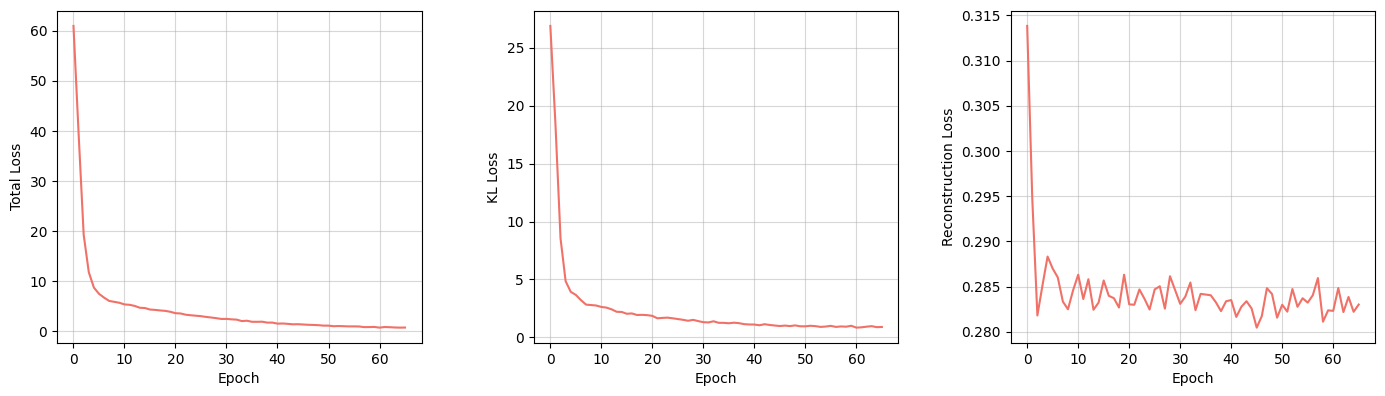

In [34]:
markov_history = np.load("markov_history.npy", allow_pickle=True).item()

plot_results(markov_history)

### Testing

we pick time t1 = 60 and sample $z_{t_{1}}$ from $P_{b}(z_{t_{1}}|b_{t1})$.

In [36]:
num_samples = 10
X_test = generate_sine_data(num_samples)

In [37]:
X_test.shape

(10, 200, 1)

In [38]:
t1 = 60
z_mean, z_log_var, z, bt = vae_markov.encoder(X_test) # z shape = (1,200,latent dim)
zt1 = z[:,t1,:] #(num_samples,latent dim)
np.shape(zt1)

TensorShape([10, 15])

Then we choose the a time interval $δ_{t} = [20,100]$ to skip, sample from the forward model $P(z_{2} | z_1, δ_{t})$ to obtain $z_{t_{2}}$ at $t_2 = t_1 +  δ_{t}$

In [39]:
def sample_gaussian(z_mean, z_log_var):
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [41]:
def vec_loss(x,z):
  return np.linalg.norm(x-z)


In [42]:
from tqdm import tqdm

def closeness(t1,z, bt):
  loss = []
  for dt in tqdm(range(20,139)):

    bt1 = bt[:,t1,:]
    bt2 = bt[:,t1 + dt,:]
    zt2 =  z[:,t1 + dt,:]
    zt1_belief = z[:, t1,:]
    dt1 = tf.fill([tf.shape(bt1)[0], 1], tf.cast(dt, dtype=zt1.dtype))
    smoothing_inputs = tf.concat((bt1,bt2,zt2, dt1), axis = -1)
    zt1_smooth, qs_mean,qs_log_var  = vae_markov.smoothing(smoothing_inputs)

    loss.append(np.mean(vec_loss(zt1_smooth, zt1_belief)))

  return loss

In [43]:
close_loss = closeness(t1,z, bt)

100%|██████████| 119/119 [00:00<00:00, 134.72it/s]


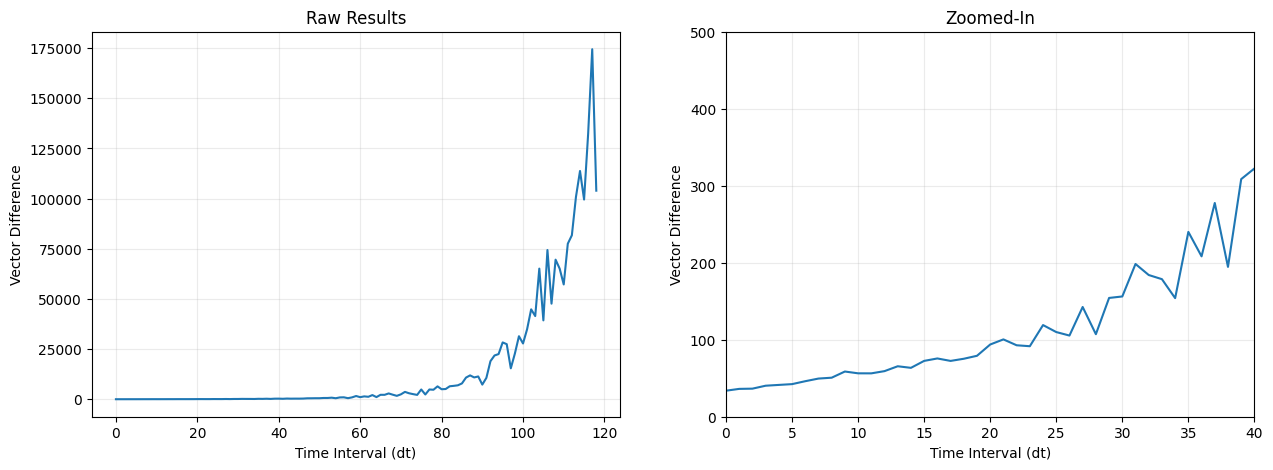

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].plot(close_loss)
ax[0].grid(True, alpha=0.25)
ax[0].set_xlabel("Time Interval (dt)")
ax[0].set_ylabel("Vector Difference")
ax[0].set_title("Raw Results")

ax[1].plot(close_loss)
ax[1].grid(True, alpha=0.25)
ax[1].set_xlabel("Time Interval (dt)")
ax[1].set_ylabel("Vector Difference")
ax[1].set_xlim(0, 40)
ax[1].set_ylim(0, 500)
ax[1].set_title("Zoomed-In")

plt.show()